![](./images/09_01.jpg)

In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/data/'

/content/gdrive/My Drive/data


In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [5]:
spark = SparkSession.builder.appName('kmeans_3D_points').getOrCreate()

# 1. Đọc dữ liệu

In [6]:
data = spark.read.csv("data3D.csv", header=True, inferSchema=True)

In [7]:
data = data.select(['x', 'y', 'z'])

In [8]:
data.show(3, False)

+-----------------+------------------+------------------+
|x                |y                 |z                 |
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328|8.963324308916228 |
|5.005396944639823|-9.301070062115645|10.35473056351597 |
+-----------------+------------------+------------------+
only showing top 3 rows



# 2. Chuẩn dữ liệu

In [9]:
from pyspark.ml.feature import VectorAssembler

In [10]:
vec_assembler = VectorAssembler(inputCols=data.columns, outputCol='features')

In [11]:
final_data = vec_assembler.transform(data)

In [12]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+
|x                |y                 |z                 |features                                                 |
+-----------------+------------------+------------------+---------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |
+-----------------+------------------+------------------+---------------------------------------------------------+
only showing top 3 rows



# 3. Scale dữ liệu

In [13]:
from pyspark.ml.feature import StandardScaler


In [14]:
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True,
                        withMean=False)

In [15]:
scaler_model =  scaler.fit(final_data)

In [16]:
final_data = scaler_model.transform(final_data)

In [17]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaled_features                                             |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042443,-1.1300631023636738]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.3213715327025202,1.3988923401033733] |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

# 4. Training model
## 4.1. Tìm $k-value$

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [19]:
k_list = []
silhouette_list = []
evaluator = ClusteringEvaluator()

for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    eva_value = evaluator.evaluate(predictions)
    k_list.append(k)
    silhouette_list.append(eva_value)
    print(f'--> With k = {k} then silhouette value = {eva_value}')

--> With k = 2 then silhouette value = 0.4700835660754471
--> With k = 3 then silhouette value = 0.9407566693614582
--> With k = 4 then silhouette value = 0.9235528500030742
--> With k = 5 then silhouette value = 0.8585695113900427
--> With k = 6 then silhouette value = 0.7282734045298034
--> With k = 7 then silhouette value = 0.6112872906361705
--> With k = 8 then silhouette value = 0.5047718651816562
--> With k = 9 then silhouette value = 0.4534409345000151
--> With k = 10 then silhouette value = 0.4543318677756431


> **Nhận xét**
> * Theo quy tắc Silhouette thì nếu giá trị Silhouette càng gần với 1 thì càng tốt, nhìn chung $k-value \in [3, 5]$ là lựa chọn tối ưu.

## 4.2. Trực quan giá trị $k-value$.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def line(a: pd.Series, b: pd.Series, title=""):
    plt.plot(a, b, 'co-')
    plt.xlabel(a.name, color='b', weight='bold')
    plt.ylabel(b.name, color='b', weight='bold')
    plt.title(title, fontsize=18, color='r', weight='bold')
    
    plt.show()

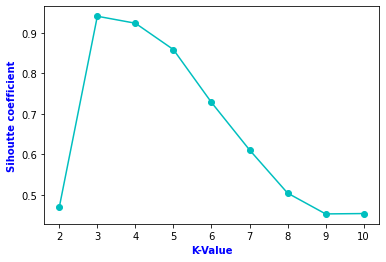

In [22]:
line(pd.Series(k_list, name='K-Value'), pd.Series(silhouette_list, name='Sihoutte coefficient'))

> **Nhận xét**
> * Chọn $k-value = 4$

## 4.3. Build model với $k-value = 4$

In [23]:
kmeans = KMeans(featuresCol='scaled_features', k=4)
model = kmeans.fit(final_data)

### 4.3.1. Tính silhouette coefficient

In [24]:
evaluator.evaluate(model.transform(final_data))

0.9235528500030742

### 4.3.2. Hiển thị các cluster center

In [25]:
centers = model.clusterCenters()

for center in centers:
    print(center)

[ 0.77554585 -0.80820119 -1.03388802]
[-1.59030525  0.93719373  0.31581855]
[ 0.74896823 -1.2269015   1.46702482]
[-0.45182036  1.15367577  0.72369935]


# 5. Dự đoán kết quả

In [26]:
predictions = model.transform(final_data)

In [27]:
predictions.select('prediction').show(5, False)

+----------+
|prediction|
+----------+
|0         |
|2         |
|2         |
|2         |
|1         |
+----------+
only showing top 5 rows



## 5.1. Đếm số lượng mẫu cho từng cluster

In [28]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|199983|
|         3|200017|
|         2|200000|
|         0|400000|
+----------+------+



## 5.2. Gộp cột `prediction` vào `final_data` cho trực quan

In [29]:
data_result = predictions.select('prediction')

In [30]:
slice_data = final_data.select('scaled_features').rdd.map(lambda x: x[0].tolist()).toDF()

In [31]:
slice_data.show(3, False)

+------------------+-------------------+-------------------+
|_1                |_2                 |_3                 |
+------------------+-------------------+-------------------+
|1.0159673512169785|-0.8133579916042443|-1.1300631023636738|
|0.7941127247055376|-1.3213715327025202|1.3988923401033733 |
|0.9004347126254749|-1.1901880174546249|1.61604698992401   |
+------------------+-------------------+-------------------+
only showing top 3 rows



In [32]:
import pyspark.sql.functions as f

In [33]:
slice_data = slice_data.withColumn('row_index', f.monotonically_increasing_id())

In [34]:
slice_data.show(5)

+-------------------+-------------------+-------------------+---------+
|                 _1|                 _2|                 _3|row_index|
+-------------------+-------------------+-------------------+---------+
| 1.0159673512169785|-0.8133579916042443|-1.1300631023636738|        0|
| 0.7941127247055376|-1.3213715327025202| 1.3988923401033733|        1|
| 0.9004347126254749|-1.1901880174546249|   1.61604698992401|        2|
|  0.741187596138339|-0.9728318176240064|  1.857214477910124|        3|
|-1.7815595725145852|  0.770202018652674|  0.319931787264219|        4|
+-------------------+-------------------+-------------------+---------+
only showing top 5 rows



In [35]:
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())

In [36]:
data_result.show(5)

+----------+---------+
|prediction|row_index|
+----------+---------+
|         0|        0|
|         2|        1|
|         2|        2|
|         2|        3|
|         1|        4|
+----------+---------+
only showing top 5 rows



In [37]:
slice_data = slice_data.join(data_result, on=['row_index']).sort('row_index').drop('row_index')

In [38]:
slice_data.show(10, False)

+--------------------+-------------------+-------------------+----------+
|_1                  |_2                 |_3                 |prediction|
+--------------------+-------------------+-------------------+----------+
|1.0159673512169785  |-0.8133579916042443|-1.1300631023636738|0         |
|0.7941127247055376  |-1.3213715327025202|1.3988923401033733 |2         |
|0.9004347126254749  |-1.1901880174546249|1.61604698992401   |2         |
|0.741187596138339   |-0.9728318176240064|1.857214477910124  |2         |
|-1.7815595725145852 |0.770202018652674  |0.319931787264219  |1         |
|-0.5683602990775889 |1.0970629584357672 |0.368058394452255  |3         |
|-1.3307463065161096 |1.029508795222231  |0.2786541199655595 |1         |
|-0.17437923969242972|1.0061668172956766 |0.505805866660319  |3         |
|0.15164684356028676 |-0.9613230903828895|-1.094297326649475 |0         |
|1.0416194796768259  |-1.5618465812109728|1.324024628261001  |2         |
+--------------------+----------------

* Đổi tên cột

In [39]:
slice_data = slice_data.select(col("_1").alias('x_scale'),
                                col("_2").alias('y_sacle'),
                                col("_3").alias('z_scale'), 'prediction')

In [40]:
slice_data.show(5, False)

+-------------------+-------------------+-------------------+----------+
|x_scale            |y_sacle            |z_scale            |prediction|
+-------------------+-------------------+-------------------+----------+
|1.0159673512169785 |-0.8133579916042443|-1.1300631023636738|0         |
|0.7941127247055376 |-1.3213715327025202|1.3988923401033733 |2         |
|0.9004347126254749 |-1.1901880174546249|1.61604698992401   |2         |
|0.741187596138339  |-0.9728318176240064|1.857214477910124  |2         |
|-1.7815595725145852|0.770202018652674  |0.319931787264219  |1         |
+-------------------+-------------------+-------------------+----------+
only showing top 5 rows



* Chuyển đổi `slice_data` thành **Pandas.DataFrame**

In [41]:
final_data_df = slice_data.toPandas()

In [42]:
final_data_df.head()

,x_scale,y_sacle,z_scale,prediction
0,1.015967,-0.813358,-1.130063,0
1,0.794113,-1.321372,1.398892,2
2,0.900435,-1.190188,1.616047,2
3,0.741188,-0.972832,1.857214,2
4,-1.781560,0.770202,0.319932,1


# 6. Trực quan hóa kết quả

In [43]:
from mpl_toolkits.mplot3d import Axes3D

In [44]:
def draw3D(pDf: pd.DataFrame):
    figure = plt.figure(figsize=(12, 8)).gca(projection="3d")
    figure.scatter(pDf.iloc[:, 0], pDf.iloc[:, 1], pDf.iloc[:, 2], c=pDf.iloc[:, 3])

    col_names = pDf.columns
    figure.set_xlabel(col_names[0])
    figure.set_ylabel(col_names[1])
    figure.set_zlabel(col_names[2])

    plt.show()

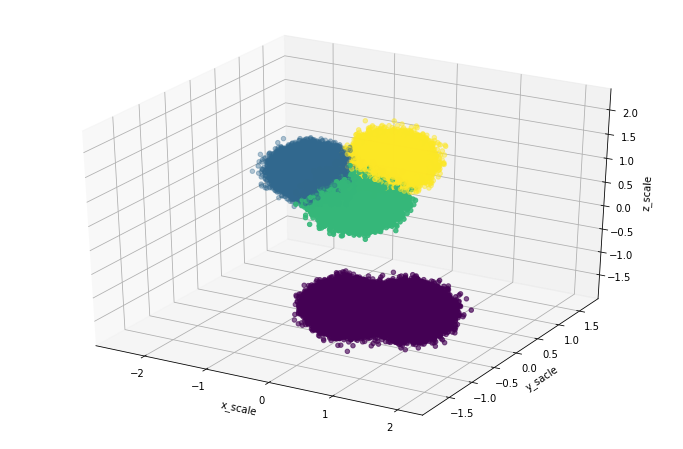

In [45]:
draw3D(final_data_df)

# 7. Combine `final_data` với `slice_data`

In [46]:
final_data = final_data.withColumn('row_index', f.monotonically_increasing_id())
slice_data = slice_data.withColumn('row_index', f.monotonically_increasing_id())

In [47]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+---------+
|x                |y                 |z                 |features                                                 |scaled_features                                             |row_index|
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+---------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042443,-1.1300631023636738]|0        |
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.3213715327025202,1.3988923401033733] |1        |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.00539

In [48]:
slice_data.show(3, False)

+------------------+-------------------+-------------------+----------+---------+
|x_scale           |y_sacle            |z_scale            |prediction|row_index|
+------------------+-------------------+-------------------+----------+---------+
|1.0159673512169785|-0.8133579916042443|-1.1300631023636738|0         |0        |
|0.7941127247055376|-1.3213715327025202|1.3988923401033733 |2         |1        |
|0.9004347126254749|-1.1901880174546249|1.61604698992401   |2         |2        |
+------------------+-------------------+-------------------+----------+---------+
only showing top 3 rows



In [49]:
final_data = final_data.join(slice_data, on=['row_index']).sort('row_index').drop('row_index')

In [50]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|x                |y                 |z                 |features                                                 |scaled_features                                             |x_scale           |y_sacle            |z_scale            |prediction|
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042443,-1.1300631023636738]|1.0159673512169785|-0.8133579916042443|-1.1300631023636738|0         |
|4.414367138